# Neural Networks
> Neural networks can be constructed using the `torch.nn` package.

## Define the network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         1 input channel and 6 output channels, 3x3 convolution
#         kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
#         affine operation y = Wx + b
        self.fc1 = nn.Linear(16*6*6, 120) # 6*6 from image dims
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
#         Max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         if the size is a square, can give 1 number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dims except the batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

10
torch.Size([6, 1, 3, 3])


Try random 32x32 input.

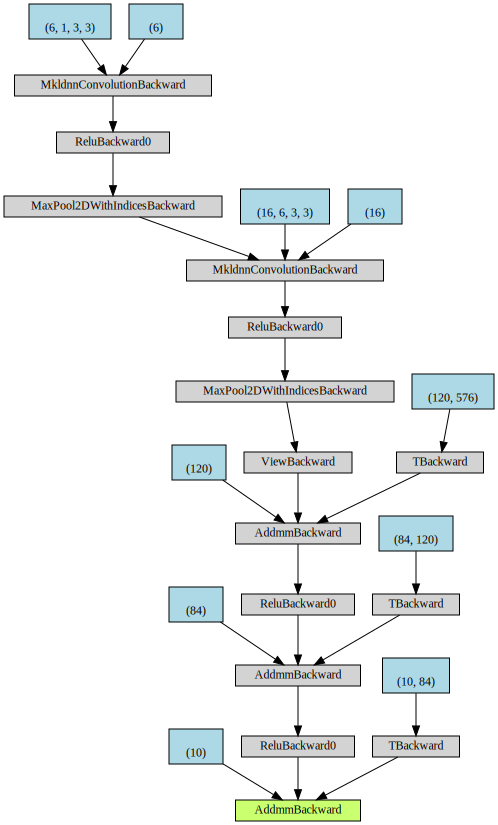

In [15]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
make_dot(out)
# print(out)

In [16]:
print(out)

tensor([[ 0.0406,  0.0512,  0.0657, -0.1179, -0.0960, -0.0107,  0.0206, -0.0440,
         -0.0677,  0.0855]], grad_fn=<AddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [7]:
net.zero_grad()
out.backward(torch.rand(1,10))

## Loss function

In [18]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1) # make it same shape as output
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(1.3563, grad_fn=<MseLossBackward>)


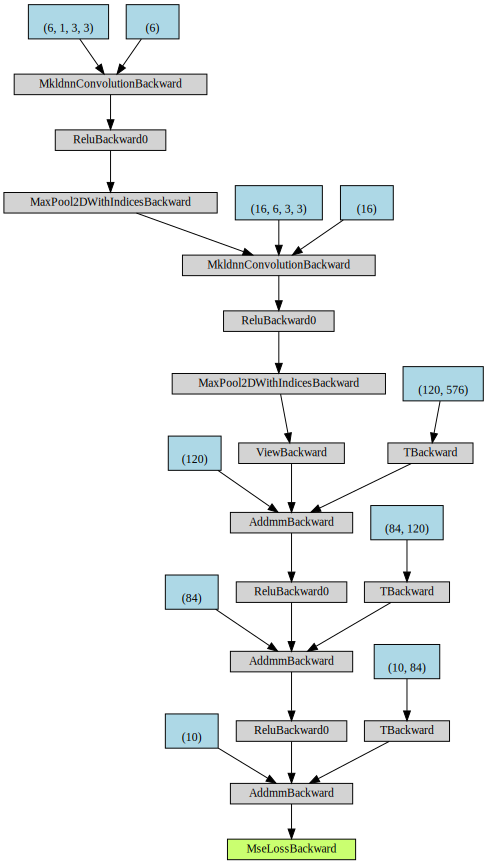

In [19]:
make_dot(loss)

In [20]:
print(loss.grad_fn) #MSE
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # Relu

## Backprop

In [21]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0003, -0.0129, -0.0008, -0.0090,  0.0164, -0.0235])


## Update weights

In [22]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

Or with optim

In [23]:
import torch.optim as optim
# create optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# in training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # update weights